In [0]:
 from google.colab import files
uploaded = files.upload()

Saving data_preparation.py to data_preparation.py


In [0]:
import tensorflow as tf
import numpy as np
import data_preparation as dp

In [0]:
rm -r Graph

rm: cannot remove 'Graph': No such file or directory


In [0]:
x_train,y_train,x_test,y_test = dp.train_test_split()

In [0]:
tf.reset_default_graph()
sess = tf.Session()

**Global Variables**

In [0]:
# number of neurons in each hidden layer
HIDDEN1_SIZE = 500
HIDDEN2_SIZE = 350
HIDDEN3_SIZE = 150

# experiment with the nubmer of training steps to see the effect
TRAIN_STEPS = 140000
BATCH_SIZE = 200
LEARNING_RATE = 0.01

NUM_CLASSES = 7
NUM_PIXELS = len(x_train[0])

In [0]:
# convert y_train and y_test to  one hot vector 

y_train_ohv = np.zeros(( len(y_train),NUM_CLASSES ))
y_train_ohv[np.arange( len(y_train) ), y_train] = 1
y_train = y_train_ohv

y_test_ohv = np.zeros(( len(y_test),NUM_CLASSES ))
y_test_ohv[np.arange( len(y_test) ), y_test] = 1
y_test = y_test_ohv

How to use Dataset in Tensorflow from [here](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428)

In [0]:
# train_data = tf.data.Dataset.from_tensor_slices( (x_train, tf.one_hot(y_train,NUM_CLASSES) ) )

Define Placeholders

In [0]:
# Define inputs

with tf.name_scope('input'):
  patches = tf.placeholder(tf.float32, [None, NUM_PIXELS], name = "patches")
  labels = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="labels")

**Define Model**

Layers API.....  Lower Level Abstraction

In [0]:
# Function to create a fully connected layer

def fc_layer(input, size_out, name = "fc", activation = None):
  with tf.name_scope(name):
    size_in = int(input.shape[1])
    w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="weights")
    b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="bias")
    wx_plus_b = tf.matmul(input, w) + b
    if activation: return activation(wx_plus_b)
    return wx_plus_b
  

# The way we initialize variables has an affect on how quickly training converges.  

In [0]:
# Define the model

# First, we'll create three fully connected layers, with ReLU activations
fc1 = fc_layer(patches, HIDDEN1_SIZE, "fc1", activation=tf.nn.relu)
fc2 = fc_layer(fc1, HIDDEN2_SIZE, "fc2", activation=tf.nn.relu)
fc3 = fc_layer(fc2, HIDDEN3_SIZE, "fc3", activation=tf.nn.relu)

# Finally, we'll calculate logists. This will be
# the input to our Softmax function. Notice we 
# don't apply an activation at this layer.

y = fc_layer(fc3, NUM_CLASSES, name="output")

In [0]:
# Define loss and an optimizer

with tf.name_scope("loss"):
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=labels))
  tf.summary.scalar('loss', loss)

with tf.name_scope("optimizer"):
  
  # Here, we're using Adagrad optimizer.
  # TensorFlow will automatically analyze our graph
  # and determine how to adjust the variables to decrease the loss.
  train = tf.train.AdagradOptimizer(LEARNING_RATE).minimize(loss)

W0712 10:47:35.192734 139681560352640 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Define evaluation

with tf.name_scope("evaluation"):
  correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(labels, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', accuracy)

In [0]:
# Set up the tensorboard

from tensorboardcolab import *
tbc = TensorBoardColab()

train_writer = tbc.get_deep_writers("train")
train_writer.add_graph(sess.graph)
test_writer = tbc.get_deep_writers("test")
test_writer.add_graph(sess.graph)

summary_op = tf.summary.merge_all()

Using TensorFlow backend.


Wait for 8 seconds...


W0712 10:47:59.943410 139681560352640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



TensorBoard link:
http://db426c25.ngrok.io


In [0]:
# Initializes all Global Variables in the Graph.

sess.run(tf.global_variables_initializer())

**Next Batch Function**

In [0]:
# Function to extract next batch of size num
BATCH_INDEX = 0       # starting index of batch to extract
IDX = None            # set of indices of all elements

def next_batch(num):
  # Return a total of num random samples and labels.
  global BATCH_INDEX         # As python have some problems with global variables
  global IDX
  
  if (BATCH_INDEX == 0):
    IDX = np.arange(0, len(y_train))   # List of indices
    np.random.shuffle(IDX)             # shuffle for randomness
    
  batch = IDX[ BATCH_INDEX:min( BATCH_INDEX + num, len(y_train) ) ]  # List of indices for batch extraction
  data_batch = [ x_train[i] for i in batch ]         # Training data of batch
  labels_batch = [ y_train[i] for i in batch ]       # Labels for batch data
  BATCH_INDEX = int( ( BATCH_INDEX + len(batch) ) % len(y_train) )   # So as to make start index = 0 after completion of 1 epoch
  return np.array(data_batch), np.array(labels_batch)  

**Training**

In [0]:
for step in range(TRAIN_STEPS):
  batch_xs, batch_ys = next_batch(BATCH_SIZE)
  summary_result, _ = sess.run( [summary_op, train], feed_dict={patches: batch_xs, labels: batch_ys} )

  train_writer.add_summary( summary_result, step )
  train_writer.add_run_metadata( tf.RunMetadata(), 'step%03d' % step )
    
  # calculate accuracy on the test set, every 1000 steps.
  # we're using the entire test set here, so this will be a bit slow
  if step % (16*100) == 0:
    summary_result, acc = sess.run( [summary_op, accuracy], feed_dict={patches: x_test, labels: y_test} )
    test_writer.add_summary(summary_result, step)
    test_writer.add_run_metadata( tf.RunMetadata(), 'step%03d' % step )
    print ( "test accuracy: %f at step %d" % (acc,step) )


print( "Accuracy %f" % sess.run( accuracy, feed_dict={patches: x_test, labels: y_test} ) )

train_writer.close()
test_writer.close()

test accuracy: 0.061992 at step 0
test accuracy: 0.801718 at step 1600
test accuracy: 0.870443 at step 3200
test accuracy: 0.897609 at step 4800
test accuracy: 0.901788 at step 6400
test accuracy: 0.919201 at step 8000
test accuracy: 0.927560 at step 9600
test accuracy: 0.937079 at step 11200
test accuracy: 0.944045 at step 12800
test accuracy: 0.946134 at step 14400
test accuracy: 0.941491 at step 16000
test accuracy: 0.947759 at step 17600
test accuracy: 0.952171 at step 19200
test accuracy: 0.956118 at step 20800
test accuracy: 0.955654 at step 22400
test accuracy: 0.957279 at step 24000
test accuracy: 0.953100 at step 25600
test accuracy: 0.953332 at step 27200
test accuracy: 0.965173 at step 28800
test accuracy: 0.962619 at step 30400
test accuracy: 0.958904 at step 32000
test accuracy: 0.965405 at step 33600
test accuracy: 0.967727 at step 35200
test accuracy: 0.967959 at step 36800
test accuracy: 0.969120 at step 38400
test accuracy: 0.968888 at step 40000
test accuracy: 0.96958

In [0]:
!pip install spectral

     |████████████████████████████████| 143kB 3.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/93/7e/15/a200ebb0b557d54eb396234737f9593ce705ed98a954bf148b
Successfully built spectral


In [0]:
import spectral

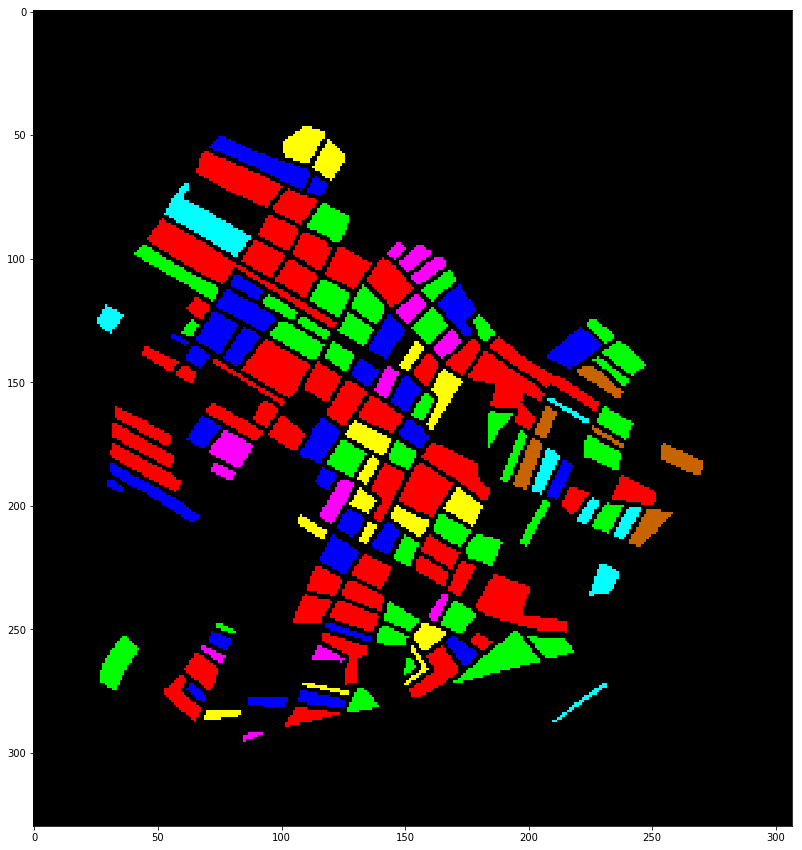

In [0]:
ground_truth = spectral.imshow( classes = dp.mat_y,figsize =(15,15) )

In [0]:
y_hat = np.zeros( (dp.HEIGHT,dp.WIDTH), dtype = int)

In [0]:
from scipy.special import softmax

for i in range(dp.HEIGHT):
    for j in range(dp.WIDTH):
      #if(dp.mat_y[i][j] ==0 ):
      #  y_hat[i][j] = 0
      #else:
      patch = dp.patch_at_index(i,j)     
      patch = np.array([patch])       # To make the dimension of patch compatible with dim of x_placeholder 
      temp = sess.run( y, feed_dict = { patches:patch } )
      temp = softmax(temp)
      y_hat[i][j] = np.argmax( temp )+1
      


      

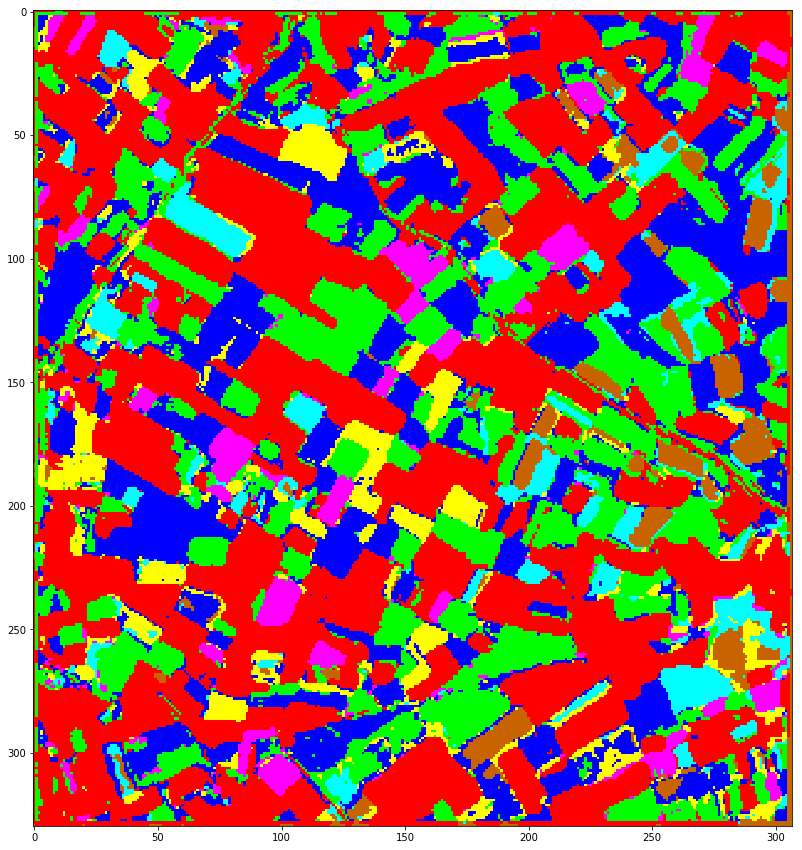

In [0]:
prediction = spectral.imshow(classes = y_hat,figsize =(15,15))
